In [37]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import os
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
#from xgboost import XGBRegressor
from shapely.geometry import Point
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
from statsmodels.formula.api import OLS

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.getcwd()

'/projects/ads_csd/shared'

In [2]:
#import taxizone shape files
taxi_zones = gpd.read_file('taxi_zones.shp')
taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [3]:
#import weather data
weather = pd.read_csv(os.getcwd()+'/'+'dat/'+'weather_2016.csv')

In [4]:
#import citbike data
citi= pd.read_csv(os.getcwd()+'/'+'dat/'+"citibike_total2016.csv")

In [5]:
citi.head()

,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


In [6]:
citi.shape

(15494511, 16)

In [7]:
citi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15494511 entries, 0 to 15494510
Data columns (total 16 columns):
Unnamed: 0                 int64
tripduration               int64
starttime                  object
stoptime                   object
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 float64
gender                     int64
dtypes: float64(5), int64(6), object(5)
memory usage: 1.8+ GB


In [8]:
#convert stop and start time to dates
citi['starttime'] = pd.to_datetime(citi['starttime'])
citi['stoptime'] = pd.to_datetime(citi['stoptime'])

In [9]:
citi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15494511 entries, 0 to 15494510
Data columns (total 16 columns):
Unnamed: 0                 int64
tripduration               int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 float64
gender                     int64
dtypes: datetime64[ns](2), float64(5), int64(6), object(3)
memory usage: 1.8+ GB


In [10]:
#drop columns not needed
citi = citi[['tripduration','starttime','stoptime','start station id','start station latitude','start station longitude', \
             'end station id','end station latitude','end station longitude']]

In [11]:
#create columns for month and day
citi['month'] = citi['starttime'].dt.month
citi['day'] = citi['starttime'].dt.day

In [12]:
citi_grouped = citi.groupby(['month','day','start station id', 'start station latitude','start station longitude', \
                             'end station id', 'end station latitude','end station longitude'])['tripduration'].agg(['sum','count'])

In [13]:
citi_grouped.head()

sum  \
month day start station id start station latitude start station longitude end station id end station latitude end station longitude         
1     1   72               40.767272              -73.993929              72             40.767272            -73.993929             1333   
                                                                          128            40.727103            -74.002971             1224   
                                                                          228            40.754601            -73.971879              825   
                                                                          304            40.704633            -74.013617             2260   
                                                                          449            40.764618            -73.987895              507   

                                                                                                                                     count  
month day start station id start station latitude start station longitude end station id end station latitude end station longitude         
1     1   72               40.767272              -73.993929              72             40.767272            -73.993929                 1  
                                                                          128            40.727103            -74.002971                 1  
                                                                          228            40.754601            -73.971879                 1  
                                                                          304            40.704633            -74.013617                 1  
                                                                          449            40.764618            -73.987895                 2

In [14]:
citi_grouped.reset_index(inplace=True)
citi_grouped.shape

(8237917, 10)

In [15]:
citi_grouped = citi_grouped.groupby(['month','day','start station id', 'start station latitude','start station longitude'])['sum'].agg(['sum','count'])
citi_grouped.head()

sum  \
month day start station id start station latitude start station longitude          
1     1   72               40.767272              -73.993929               18051   
          79               40.719116              -74.006667               21164   
          82               40.711174              -74.000165               13237   
          83               40.683826              -73.976323               20545   
          116              40.741776              -74.001497               31598   

                                                                           count  
month day start station id start station latitude start station longitude         
1     1   72               40.767272              -73.993929                  15  
          79               40.719116              -74.006667                  16  
          82               40.711174              -74.000165                  11  
          83               40.683826              -73.976323                  14  
          116              40.741776              -74.001497                  33

In [16]:
citi_grouped.reset_index(inplace=True)
citi_grouped.shape

(184681, 7)

In [17]:
citi_grouped.head()

,month,day,start station id,start station latitude,start station longitude,sum,count
0,1,1,72,40.767272,-73.993929,18051,15
1,1,1,79,40.719116,-74.006667,21164,16
2,1,1,82,40.711174,-74.000165,13237,11
3,1,1,83,40.683826,-73.976323,20545,14
4,1,1,116,40.741776,-74.001497,31598,33


In [18]:
#convert citi bike to geopandas dataframe
geometry = [Point(xy) for xy in zip(citi_grouped['start station longitude'], citi_grouped['start station latitude'])]
crs = {'init': 'epsg:4326'}
citi_geo = gpd.GeoDataFrame(citi_grouped, crs=crs, geometry=geometry)

In [19]:
taxi_zones = taxi_zones.to_crs(crs)

In [20]:
#spatial join to taxi zone data
citi_geo = gpd.sjoin(citi_geo,taxi_zones,how='left')
citi_geo.head()

,month,day,start station id,start station latitude,start station longitude,sum,count,geometry,index_right,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,1,1,72,40.767272,-73.993929,18051,15,POINT (-73.99392888 40.76727216),49.0,50.0,0.055748,0.000173,Clinton West,50.0,Manhattan
1,1,1,79,40.719116,-74.006667,21164,16,POINT (-74.00666661 40.71911552),230.0,231.0,0.063420,0.000167,TriBeCa/Civic Center,231.0,Manhattan
2,1,1,82,40.711174,-74.000165,13237,11,POINT (-74.00016545 40.71117416),44.0,45.0,0.045907,0.000091,Chinatown,45.0,Manhattan
3,1,1,83,40.683826,-73.976323,20545,14,POINT (-73.97632328 40.68382604),96.0,97.0,0.062476,0.000163,Fort Greene,97.0,Brooklyn
4,1,1,116,40.741776,-74.001497,31598,33,POINT (-74.00149746 40.74177603),67.0,68.0,0.049337,0.000111,East Chelsea,68.0,Manhattan


In [21]:
#citi_agg = pd.DataFrame(citi_geo)
citi_agg = citi_geo.groupby(['month','day','OBJECTID'])['sum'].agg(['sum','count'])
citi_agg.head()

sum  count
month day OBJECTID               
1     1   4.0       119672      7
          12.0       34150      1
          13.0      348107      5
          17.0       56285     21
          25.0       32991      4

In [22]:
citi_agg.reset_index(inplace=True)
citi_agg.head()

,month,day,OBJECTID,sum,count
0,1,1,4.0,119672,7
1,1,1,12.0,34150,1
2,1,1,13.0,348107,5
3,1,1,17.0,56285,21
4,1,1,25.0,32991,4


In [23]:
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TAVG
0,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.0,0.0,0.0,42
1,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-02,0.0,0.0,0.0,37
2,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-03,0.0,0.0,0.0,40
3,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-04,0.0,0.0,0.0,34
4,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-05,0.0,0.0,0.0,20


In [25]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 10 columns):
STATION      1101 non-null object
NAME         1101 non-null object
LATITUDE     1101 non-null float64
LONGITUDE    1101 non-null float64
ELEVATION    1101 non-null float64
DATE         1101 non-null object
PRCP         1101 non-null float64
SNOW         1101 non-null float64
SNWD         1101 non-null float64
TAVG         1101 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 86.1+ KB


In [24]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['month'] = weather['DATE'].dt.month
weather['day'] = weather['DATE'].dt.day

In [25]:
weather['year'] = weather['DATE'].dt.year

In [26]:
weather = weather[(weather['STATION'] == 'USW00014732') & (weather['year'] == 2016)]

In [27]:
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TAVG,month,day,year
0,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.0,0.0,0.0,42,1,1,2016
1,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-02,0.0,0.0,0.0,37,1,2,2016
2,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-03,0.0,0.0,0.0,40,1,3,2016
3,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-04,0.0,0.0,0.0,34,1,4,2016
4,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-05,0.0,0.0,0.0,20,1,5,2016


In [28]:
citi_weather = pd.merge(left=citi_agg,right=weather,left_on=['month','day'],right_on=['month','day'])
citi_weather.head()

,month,day,OBJECTID,sum,count,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TAVG,year
0,1,1,4.0,119672,7,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.0,0.0,0.0,42,2016
1,1,1,12.0,34150,1,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.0,0.0,0.0,42,2016
2,1,1,13.0,348107,5,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.0,0.0,0.0,42,2016
3,1,1,17.0,56285,21,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.0,0.0,0.0,42,2016
4,1,1,25.0,32991,4,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.0,0.0,0.0,42,2016


In [29]:
citi_weather.shape

(26956, 16)

In [30]:
citi_agg.shape

(26956, 5)

In [31]:
citi_weather = citi_weather[['OBJECTID','month','day','count','PRCP','SNOW','SNWD','TAVG']]
citi_weather.head()

,OBJECTID,month,day,count,PRCP,SNOW,SNWD,TAVG
0,4.0,1,1,7,0.0,0.0,0.0,42
1,12.0,1,1,1,0.0,0.0,0.0,42
2,13.0,1,1,5,0.0,0.0,0.0,42
3,17.0,1,1,21,0.0,0.0,0.0,42
4,25.0,1,1,4,0.0,0.0,0.0,42


In [32]:
one_hots = citi_weather[['month','OBJECTID']].values
inputs = citi_weather[['day','count','PRCP','SNOW','SNWD','TAVG']]

In [33]:
enc = OneHotEncoder()
one_hots_trans = enc.fit_transform(one_hots).toarray()

/nfshome/cb4102/.conda/envs/geoplot/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [34]:
one_hots_trans = pd.DataFrame(one_hots_trans)
one_hots_trans.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
one_hots_trans.shape

(26956, 94)

In [36]:
regression_input = pd.merge(left=inputs,right=one_hots_trans,left_index=True,right_index=True)
regression_input.head()

,day,count,PRCP,SNOW,SNWD,TAVG,0,1,2,3,...,84,85,86,87,88,89,90,91,92,93
0,1,7,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,5,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,21,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,4,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
Y = regression_input['count']
X = regression_input.iloc[:,2:]
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [40]:
node_level = OLS(Y,X).fit()

In [42]:
node_level.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     2684.
Date:                Wed, 19 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:41:43   Log-Likelihood:                -46780.
No. Observations:               26956   AIC:                         9.375e+04
Df Residuals:                   26859   BIC:                         9.455e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PRCP          -0.0219      0.031     -0.717      0.473      -0.082       0.038
SNOW           0.1119      0.040      2.765      0.006       0.033       0.191
SNWD          -0.2787      0.015    -18.463      0.000      -0.308      -0.249
TAVG           0.0010      0.001      0.868      0.386      -0.001       0.003
0              5.6197      0.047    118.609      0.000       5.527       5.713
1              5.5978      0.049    114.622      0.000       5.502       5.694
2              5.5790      0.057     98.297      0.000       5.468       5.690
3              5.5710      0.061     91.629      0.000       5.452       5.690
4              5.5191      0.071     77.259      0.000       5.379       5.659
5              5.5259      0.083     66.860      0.000       5.364       5.688
6              5.5702      0.090     61.710      0.000       5.393       5.747
7              5.6764      0.091     62.688      0.000       5.499       5.854
8              6.1289      0.082     74.474      0.000       5.968       6.290
9              6.3606      0.068     93.313      0.000       6.227       6.494
10             6.3237      0.059    106.451      0.000       6.207       6.440
11             6.3949      0.048    133.428      0.000       6.301       6.489
12             1.1222      0.072     15.491      0.000       0.980       1.264
13            -4.8688      0.073    -67.121      0.000      -5.011      -4.727
14            -0.8640      0.072    -11.927      0.000      -1.006      -0.722
15            14.8874      0.072    205.510      0.000      14.745      15.029
16            -2.3875      0.115    -20.814      0.000      -2.612      -2.163
17             0.8708      0.072     12.021      0.000       0.729       1.013
18             4.3901      0.072     60.603      0.000       4.248       4.532
19            -2.2369      0.072    -30.879      0.000      -2.379      -2.095
20            -2.8778      0.072    -39.726      0.000      -3.020      -2.736
21             3.9112      0.120     32.522      0.000       3.675       4.147
22             3.2686      0.072     45.121      0.000       3.127       3.411
23             0.1250      0.072      1.725      0.085      -0.017       0.267
24             5.9261      0.072     81.805      0.000       5.784       6.068
25             7.1222      0.072     98.317      0.000       6.980       7.264
26            -2.8695      0.072    -39.612      0.000      -3.012      -2.728
27            -2.4638      0.118    -20.955      0.000      -2.694      -2.233
28            -3.7723      0.073    -51.926      0.000      -3.915      -3.630
29            -3.8983      0.073    -53.660      0.000      -4.041      -3.756
30             1.5172      0.072     20.944      0.000       1.375       1.659
31             0.1056      0.072      1.458      0.145      -0.036       0.248
32

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
lin_reg.score(X_train,y_train)

0.9080202767368638

In [41]:
lin_reg.score(X_test,y_test)

0.8977252893897324

In [42]:
from sklearn.metrics import mean_squared_error

mean_squared_error(lin_reg.predict(X_test), y_test)

2.0137890012676443

In [43]:
X

,PRCP,SNOW,SNWD,TAVG,0,1,2,3,4,5,...,84,85,86,87,88,89,90,91,92,93
0,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,42,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
lin_reg.coef_

array([ 7.18508019e-04,  5.97503305e-02, -2.92774312e-01,  1.53865694e-03,
       -1.55392704e-01, -2.02059486e-01, -2.60228831e-01, -2.34079467e-01,
       -3.22220298e-01, -3.16061079e-01, -2.65703188e-01, -1.52028743e-01,
        2.92991284e-01,  5.38986119e-01,  4.98782214e-01,  5.77014180e-01,
        2.51562374e-01, -5.73146599e+00, -1.72342831e+00,  1.40357636e+01,
       -3.25043338e+00,  7.33619603e-02,  3.54195252e+00, -3.08565333e+00,
       -3.71947746e+00,  2.94275311e+00,  2.42909283e+00, -7.29383473e-01,
        5.07120194e+00,  6.25153147e+00, -3.72653318e+00, -3.29861215e+00,
       -4.64863810e+00, -4.76239553e+00,  6.61093451e-01, -7.58161146e-01,
        5.79967295e+00,  6.66736720e+00,  6.49576874e+00,  6.63387986e+00,
        3.21751510e+00, -3.76864472e+00, -2.79276830e+00,  1.11127771e+01,
       -1.01195059e+00, -4.71852052e+00, -1.51629783e-02, -9.60229745e-01,
        7.02048102e+00,  3.83701041e+00, -2.00133918e+00, -2.19678189e+00,
       -7.26525343e-01, -

In [45]:
lin_reg.intercept_

6.651906044539204

In [46]:
dir(LinearRegression())

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_preprocess_data',
 '_set_intercept',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'n_jobs',
 'normalize',
 'predict',
 'score',
 'set_params']

In [ ]:
f_regression(X_train,y_train)

In [ ]:
citi_weather.to_csv('citibike_with_weather.csv')

In [ ]:
citi_weather.head()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.plot(citi_weather['TAVG'])

ax.plot(citi_weather['count'])

## Making Plots 
### Fig. 1 Taxi & Citi (Volume) vs. Tempeature and Precipitation

In [48]:
citi_agg.head()

,month,day,OBJECTID,sum,count
0,1,1,4.0,119672,7
1,1,1,12.0,34150,1
2,1,1,13.0,348107,5
3,1,1,17.0,56285,21
4,1,1,25.0,32991,4


In [ ]:
viz_dta = citi_agg.merge(
    citi_weather
    , on = [
        'month'
        , 'day'
        , 'OBJECTID'
    ]
)
viz_dta.head()

In [ ]:
viz_dta = viz_dta.groupby('TAVG').sum()
viz_dta.head()

In [ ]:
viz_dta.rename(
    {'count_x': 'ride_count'}
    , axis=1
    , inplace=True
)
viz_dta.reset_index(inplace=True)
viz_dta.head()

In [ ]:
plt.cla()
plt.clf()

In [ ]:
viz_dta.plot('TAVG', 'ride_count', kind='bar', color='b', figsize=(16, 12))
ax.set_xlabel('Temperature in Fahrenheit', fontsize=16)
ax.set_ylabel('Sum of All rides w.r.t. Temperature', fontsize=16)
ax.set_title('Citibike Ride Counts vs. Temperature', fontsize=20)
fig = plt.gcf()
fig.savefig('/projects/ads_csd/shared/viz/ride_counts_vs_temp_citibikes_total.png')

In [ ]:
precip_citi = citi_weather[
        (citi_weather['PRCP'] > 0)
]

In [ ]:
viz_dta_prep = citi_agg.merge(
    precip_citi
    , on = [
        'month'
        , 'day'
        , 'OBJECTID'
    ]
)
viz_dta_prep.head()

In [ ]:
viz_dta_prep['PRCP1'] = viz_dta_prep['PRCP'].apply(lambda f: float('%.1f' % f))
viz_dta_prep = viz_dta_prep.groupby('PRCP1').sum()['count_x']
viz_dta_prep = viz_dta_prep.reset_index()

In [78]:
viz_dta_prep.tail()

,PRCP1,count_x
11,1.4,461
12,1.5,465
13,1.6,1046
14,1.8,593
15,2.2,591


In [ ]:
viz_dta_prep.rename(
    {'count_x': 'rides_count'}
    , axis=1
    , inplace=True
)
viz_dta_prep.reset_index(inplace=True)

In [ ]:
ax = viz_dta_prep.plot('PRCP1', 'rides_count', kind='bar', color='b', figsize=(16, 12))
ax.set_xlabel('Precipitation in inches per day rounded to 1 decimal', fontsize=16)
ax.set_ylabel('Sum of All rides w.r.t. Precipitation', fontsize=16)
ax.set_title('Citibike Ride Counts vs. Percipitation in NYC in Days with Precipitation', fontsize=20)
fig = plt.gcf()
fig.savefig('/projects/ads_csd/shared/viz/ride_counts_vs_prcp_citibikes_with_precipitation.png')

### now without precipitation

In [ ]:
nonprecip_citi = citi_weather[
        (citi_weather['PRCP'] == 0) |
        (citi_weather['SNOW'] == 0) |
        (citi_weather['SNWD'] == 0) 
]

In [ ]:
viz_dta_noprep = citi_agg.merge(
    nonprecip_citi
    , on = [
        'month'
        , 'day'
        , 'OBJECTID'
    ]
)
viz_dta_noprep.head()

In [ ]:
viz_dta_noprep = viz_dta_noprep.groupby('TAVG').sum()
viz_dta_noprep.head()

In [ ]:
viz_dta_noprep.rename(
    {'count_x': 'ride_count'}
    , axis=1
    , inplace=True
)
viz_dta_noprep.reset_index(inplace=True)

In [ ]:
viz_dta_noprep.plot('TAVG', 'ride_count', kind='bar', color='b', figsize=(16, 12))
ax.set_xlabel('Average Temperature in Fahrenheit')
ax.set_ylabel('Sum of All rides w.r.t. Temperature')
ax.set_title('Ride Counts vs. Average Temperature in NYC without Precipitation')
fig = plt.gcf()
fig.savefig('/projects/ads_csd/shared/viz/ride_counts_vs_temp_citibikes_no_precipitation.png')

### cumulative distribution

In [43]:
citi_weather.head()

,OBJECTID,month,day,count,PRCP,SNOW,SNWD,TAVG
0,4.0,1,1,7,0.0,0.0,0.0,42
1,12.0,1,1,1,0.0,0.0,0.0,42
2,13.0,1,1,5,0.0,0.0,0.0,42
3,17.0,1,1,21,0.0,0.0,0.0,42
4,25.0,1,1,4,0.0,0.0,0.0,42


In [53]:
citi_cum = citi_weather.groupby(['OBJECTID'])['count'].sum()

In [45]:
citi_cum.head()

OBJECTID
4.0     2528
12.0     361
13.0    1809
17.0    7511
24.0     555
Name: count, dtype: int64

In [46]:
citi_cum = pd. DataFrame(citi_cum)
citi_cum.head()

,count
OBJECTID,
4.0,2528
12.0,361
13.0,1809
17.0,7511
24.0,555


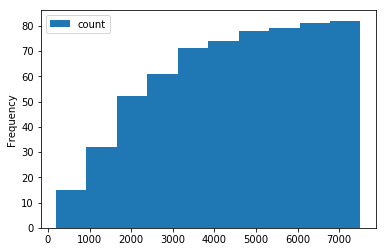

In [49]:
citi_cum.plot(kind='hist',cumulative=True)

In [50]:
citi_cum.sum()

count    184676
dtype: int64

In [63]:
cum_ = citi_weather.groupby(['OBJECTID'])['count'].sum().values

In [64]:
print(cum_)

[2528  361 1809 7511  555 2437 3711 1312 1080 1330 3305 2167 4267 4700
 1083  521  755  707 2671 2160 4542 2056 4783 4823 3599 1067 1423 6465
 2062  251  957 2071 4961 3822 1710 1641 2166  823 2830 1802 2279 1739
 3217  362 3537  965 2098 2403 2498 1080 1803 3839 3023 1402  270  357
  350 1540  722 1080 1067 1730 3200  672  195 1385 1664 5735 4310 2132
 2532 1830 2265 1099 3340 2493 2354 6069 3591  720 1225 1680]


In [65]:
cum_.sort()
print(cum_)

[ 195  251  270  350  357  361  362  521  555  672  707  720  722  755
  823  957  965 1067 1067 1080 1080 1080 1083 1099 1225 1312 1330 1385
 1402 1423 1540 1641 1664 1680 1710 1730 1739 1802 1803 1809 1830 2056
 2062 2071 2098 2132 2160 2166 2167 2265 2279 2354 2403 2437 2493 2498
 2528 2532 2671 2830 3023 3200 3217 3305 3340 3537 3591 3599 3711 3822
 3839 4267 4310 4542 4700 4783 4823 4961 5735 6069 6465 7511]


In [66]:
cum_ = np.flip(cum_, axis=-1)
print(cum_)

[7511 6465 6069 5735 4961 4823 4783 4700 4542 4310 4267 3839 3822 3711
 3599 3591 3537 3340 3305 3217 3200 3023 2830 2671 2532 2528 2498 2493
 2437 2403 2354 2279 2265 2167 2166 2160 2132 2098 2071 2062 2056 1830
 1809 1803 1802 1739 1730 1710 1680 1664 1641 1540 1423 1402 1385 1330
 1312 1225 1099 1083 1080 1080 1080 1067 1067  965  957  823  755  722
  720  707  672  555  521  362  361  357  350  270  251  195]


In [67]:
tot = cum_.sum()
print(tot)

184676


In [70]:
cum_t = cum_ / tot
print(cum_t)

[0.04067123 0.03500726 0.03286296 0.03105439 0.02686326 0.02611601
 0.02589941 0.02544998 0.02459442 0.02333817 0.02310533 0.02078776
 0.0206957  0.02009465 0.01948818 0.01944487 0.01915246 0.01808573
 0.01789621 0.0174197  0.01732764 0.01636921 0.01532414 0.01446317
 0.0137105  0.01368884 0.01352639 0.01349932 0.01319608 0.01301198
 0.01274665 0.01234053 0.01226472 0.01173406 0.01172865 0.01169616
 0.01154454 0.01136044 0.01121423 0.0111655  0.01113301 0.00990925
 0.00979553 0.00976304 0.00975763 0.00941649 0.00936776 0.00925946
 0.00909701 0.00901037 0.00888583 0.00833893 0.00770539 0.00759167
 0.00749962 0.0072018  0.00710433 0.00663324 0.00595096 0.00586432
 0.00584808 0.00584808 0.00584808 0.00577769 0.00577769 0.00522537
 0.00518205 0.00445645 0.00408824 0.00390955 0.00389872 0.00382833
 0.00363881 0.00300526 0.00282116 0.00196019 0.00195477 0.00193312
 0.00189521 0.00146202 0.00135914 0.0010559 ]


In [71]:
cum_ = cum_t.cumsum()
print(cum_)

[0.04067123 0.07567849 0.10854145 0.13959583 0.1664591  0.1925751
 0.21847452 0.24392449 0.26851892 0.29185709 0.31496242 0.33575018
 0.35644588 0.37654054 0.39602872 0.41547359 0.43462605 0.45271178
 0.47060798 0.48802768 0.50535533 0.52172453 0.53704867 0.55151184
 0.56522234 0.57891117 0.59243757 0.60593688 0.61913297 0.63214495
 0.64489159 0.65723213 0.66949685 0.68123091 0.69295956 0.70465572
 0.71620026 0.7275607  0.73877494 0.74994044 0.76107345 0.77098269
 0.78077823 0.79054127 0.8002989  0.80971539 0.81908315 0.82834261
 0.83743962 0.84645    0.85533583 0.86367476 0.87138015 0.87897182
 0.88647144 0.89367324 0.90077758 0.90741082 0.91336178 0.9192261
 0.92507418 0.93092226 0.93677034 0.94254803 0.94832572 0.95355108
 0.95873313 0.96318959 0.96727783 0.97118738 0.9750861  0.97891442
 0.98255323 0.98555849 0.98837965 0.99033984 0.99229461 0.99422773
 0.99612294 0.99758496 0.9989441  1.        ]


Text(0.5, 1.0, 'Cumulative Distribution of Citibike Rides by Taxi Zone, 2016-2017')

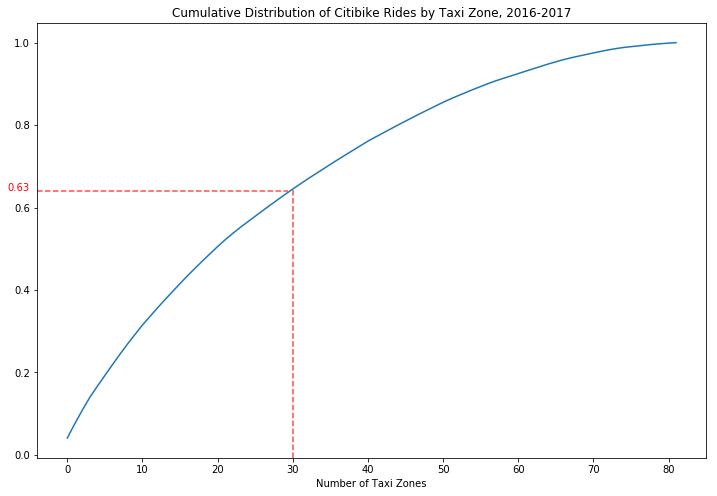

In [105]:
fig_cum, ax = plt.subplots()

fig_cum.set_size_inches(2 * fig_cum.get_size_inches())

ax.plot(np.arange(0, cum_.shape[0]), cum_)

ax.axvline(x=30,ymax=0.62,linestyle='--',color='red',alpha=0.7)
ax.axhline(y=0.64,xmax=30/80,linestyle='--',color='red',alpha=0.7)
ax.text(x=-8,y=0.64,s="0.63",color='red')
ax.set_xlabel("Number of Taxi Zones")
ax.set_title("Cumulative Distribution of Citibike Rides by Taxi Zone, 2016-2017")

In [106]:
citi_weather.head()

,OBJECTID,month,day,count,PRCP,SNOW,SNWD,TAVG
0,4.0,1,1,7,0.0,0.0,0.0,42
1,12.0,1,1,1,0.0,0.0,0.0,42
2,13.0,1,1,5,0.0,0.0,0.0,42
3,17.0,1,1,21,0.0,0.0,0.0,42
4,25.0,1,1,4,0.0,0.0,0.0,42


In [108]:
citi_day = citi_weather.groupby(['month','day'])['count'].sum()
citi_day = pd.DataFrame(citi_day)

In [110]:
citi_day.reset_index(inplace=True)
citi_day.head()

,month,day,count
0,1,1,460
1,1,2,462
2,1,3,461
3,1,4,467
4,1,5,468


In [ ]:
citi_day = pd.merge(left=citi_day,right=)

In [111]:
time_series = pd.merge(left=citi_day,right=weather,left_index=True,right_index=True)
time_series.head(10)

,month_x,day_x,count,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TAVG,month_y,day_y,year
0,1,1,460,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-01,0.00,0.0,0.0,42,1,1,2016
1,1,2,462,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-02,0.00,0.0,0.0,37,1,2,2016
2,1,3,461,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-03,0.00,0.0,0.0,40,1,3,2016
3,1,4,467,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-04,0.00,0.0,0.0,34,1,4,2016
4,1,5,468,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-05,0.00,0.0,0.0,20,1,5,2016
5,1,6,469,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-06,0.00,0.0,0.0,32,1,6,2016
6,1,7,467,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-07,0.00,0.0,0.0,39,1,7,2016
7,1,8,465,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-08,0.00,0.0,0.0,40,1,8,2016
8,1,9,463,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-09,0.00,0.0,0.0,44,1,9,2016
9,1,10,461,USW00014732,"LA GUARDIA AIRPORT, NY US",40.7792,-73.88,3.4,2016-01-10,1.42,0.0,0.0,51,1,10,2016


In [114]:
time_series = time_series[['count','DATE']]

In [116]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 361
Data columns (total 2 columns):
count    362 non-null int64
DATE     362 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.5 KB
